In [1]:
##Downloaded to my PC 3/15/22

# Finding Heavy Traffic Indicators on I-94

## Introduction 

I-94 is an east–west Interstate Highway stretching from  Port Huron, Michigan to Billings, Montana.  It connects the Great Lakes and northern Great Plains regions of the United States.   The [dataset](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) was downloaded from the UCI Machine Learning Repository, as made available by John Hogue. According to the dataset documentation, all of the data is for westbound traffic, recorded at a staion approximatly halfway between Minneapolis and Saint Paul, Minnesota. Unfortunately this prevents us from making any assumptions about eastbound traffic. 

In this notebook we'll be looking to determine some indicators on I-94, such as weather, time of day, season, etc.

# First Look at the Data

We begin by importing libraries and getting our first look at the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

In [2]:
traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


We have 9 columns, all related to traffic volume, date/time/holiday and deteorological data.  The documentation gives us definitions for each of the columns:
- holiday: Categorical US National holidays plus regional holiday, Minnesota State Fair
-temp: Numeric Average temp in kelvin
-rain:_1h Numeric Amount in mm of rain that occurred in the hour
-snow_1h: Numeric Amount in mm of snow that occurred in the hour
-clouds_all: Numeric Percentage of cloud cover
-weather_main: Categorical Short textual description of the current weather
-weather_description: Categorical Longer textual description of the current weather
-date_time: DateTime Hour of the data collected in local CST time
-traffic_volume: Numeric Hourly I-94 ATR 301 reported westbound traffic volume



Since the traffic volume is our main interest, we'll take a look at it first. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd48addeaf0>]],
      dtype=object)

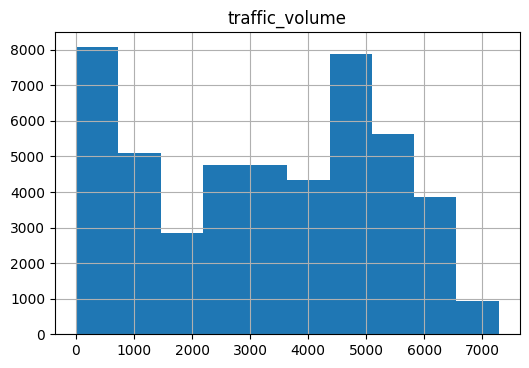

In [4]:
traffic.hist('traffic_volume')

In [5]:
traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

We see that most of the values fall in 2 ranges.  There are approximately 8000 recordings each in the 0-500 and 4500-5000 vehicles per hour ranges.  Occasionally (about 100 times), we see volumes up into the lower 7000 range (7280 max).  There are even some records of 0 vehicles per hour.  

## Traffic Volume: Day vs. Night

Based on common traffic pattern, it is reasonable to hypothesize that the lowest volumes are at night and the highest ones occur during the day, possibly during rush hours and/or holidays. To test this hypothesis, we can divide the dataset into 2 parts, 12 hours each, from 7 A.M. to 7 P.M. (daytime) and 7 P.M. to 7 A.M. (night time).  This is just a starting point and may need editing based on our findings. 

In [6]:
traffic['date_time'] = pd.to_datetime(traffic['date_time'])
traffic = traffic.set_index(pd.DatetimeIndex(traffic['date_time']))
pd.to_datetime(traffic['date_time']).dt.hour

date_time
2012-10-02 09:00:00     9
2012-10-02 10:00:00    10
2012-10-02 11:00:00    11
2012-10-02 12:00:00    12
2012-10-02 13:00:00    13
                       ..
2018-09-30 19:00:00    19
2018-09-30 20:00:00    20
2018-09-30 21:00:00    21
2018-09-30 22:00:00    22
2018-09-30 23:00:00    23
Name: date_time, Length: 48204, dtype: int64

In [7]:
day = traffic[(traffic['date_time'].dt.hour >= 7) &
                (traffic['date_time'].dt.hour < 19)].copy()
day

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
date_time,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.00,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,None,289.36,0.00,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,None,289.58,0.00,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,None,290.13,0.00,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,None,291.14,0.00,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
2018-09-30 15:00:00,None,283.84,0.00,0.0,75,Rain,proximity shower rain,2018-09-30 15:00:00,4302
2018-09-30 15:00:00,None,283.84,0.00,0.0,75,Drizzle,light intensity drizzle,2018-09-30 15:00:00,4302
2018-09-30 16:00:00,None,284.38,0.00,0.0,75,Rain,light rain,2018-09-30 16:00:00,4283


In [8]:
night = traffic[(traffic['date_time'].dt.hour < 7) |
                (traffic['date_time'].dt.hour >= 19)].copy()
night

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
date_time,,,,,,,,,
2012-10-02 19:00:00,None,290.97,0.0,0.0,20,Clouds,few clouds,2012-10-02 19:00:00,3539
2012-10-02 20:00:00,None,289.38,0.0,0.0,1,Clear,sky is clear,2012-10-02 20:00:00,2784
2012-10-02 21:00:00,None,288.61,0.0,0.0,1,Clear,sky is clear,2012-10-02 21:00:00,2361
2012-10-02 22:00:00,None,287.16,0.0,0.0,1,Clear,sky is clear,2012-10-02 22:00:00,1529
2012-10-02 23:00:00,None,285.45,0.0,0.0,1,Clear,sky is clear,2012-10-02 23:00:00,963
...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
2018-09-30 20:00:00,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
2018-09-30 21:00:00,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159


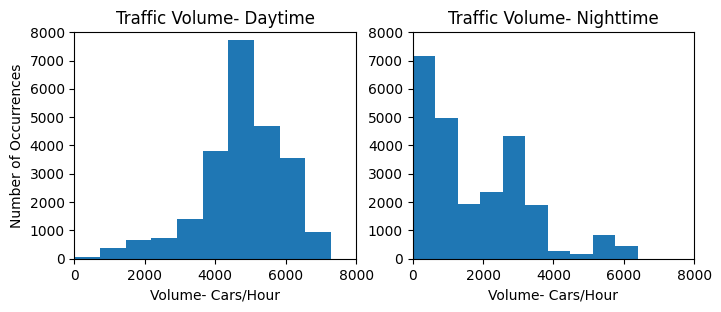

In [9]:
plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
plt.title('Traffic Volume- Daytime')
plt.xlabel('Volume- Cars/Hour')
plt.ylabel('Number of Occurrences')

plt.xlim(0,8000)
plt.ylim(0,8000)


plt.hist(day['traffic_volume'])

plt.subplot(1, 2, 2)
plt.ylim(0,8000)
plt.xlim(0,8000)
plt.hist(night['traffic_volume'])
plt.xlabel('Volume- Cars/Hour')


plt.title('Traffic Volume- Nighttime')
plt.show()

It appears most of our daytime values center around 5000 vehicles per hour, while at nighttime they are much lower, with most of the counts falling between 0 and 4000 vehicles per hour. Since we are interested in determining the causes of high traffic volume, we may want to consider not using the night data.  We can look at the statistics of the day vs. the night data to help make that decision. 

In [10]:
day['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [11]:
night['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

When we ran pd.describe on all of the data, we saw a median value of 3380.  We can now see that at night more than 75% of the values fall below that and during the day more than 75% are above it.  Based on this, we can choose to focus solely on the daytime data. 

## Time Indicators

Having narrowed down our data to focus on daytime hours, we can now look at what time and date factors might contribute to heavier traffic. We will look at how the parameters of month, day of the week and time of day influence the volume. 

### By Month

First we'll look at volume by month of the year.  We'll need to create a column for the month and then group by that column to get an average value.

In [12]:
day['month'] = day['date_time'].dt.month

by_month = day.groupby('month').mean()
by_month['traffic_volume']

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

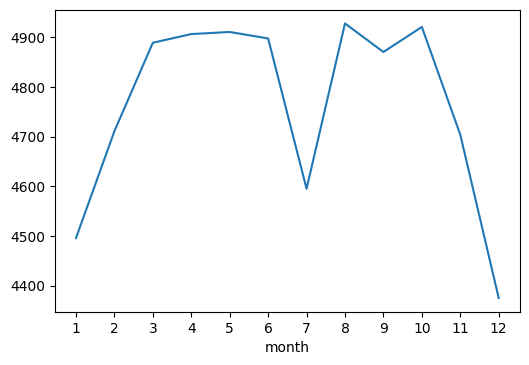

In [13]:
by_month['traffic_volume'].plot()
plt.xticks(range(1,13))
plt.show()

### By Day of the Week

Traffic is lowest during the winter months, particularly Decenber and January, and peaks in the summer.  The one exception to this pattern is July, when it falls back near to but not quite the winter values. Now let's look at traffic by day of week.

In [14]:
day['dayofweek'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('dayofweek').mean()
by_dayofweek['traffic_volume']  # 0 is Monday, 6 is Sunday

dayofweek
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64

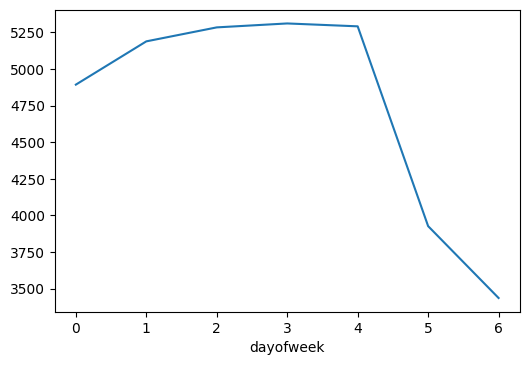

In [15]:
by_dayofweek['traffic_volume'].plot()
plt.show()

### By Hour
The weekends, particularly Sunday have the lowest volumes.  There is also a small upward trend between Monday and Friday.

Our last time indicator is hour.  As we just discovered, the weekends have lower volumes, so we'll want to exclude them so they don't skew our values. 

In [16]:
day['hour'] = day['date_time'].dt.hour
bussiness_days = day.copy()[day['dayofweek'] <= 4] # 4 == Friday
weekend = day.copy()[day['dayofweek'] >= 5] # 5 == Saturday
by_hour_business = bussiness_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

print(by_hour_business['traffic_volume'])
print(by_hour_weekend['traffic_volume'])

hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64
hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64


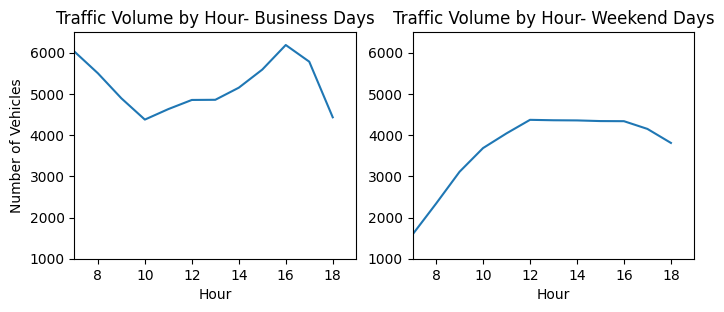

In [17]:
plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
plt.title('Traffic Volume by Hour- Business Days')
plt.xlabel('Hour')
plt.ylabel('Number of Vehicles')

plt.xlim(7,19)
plt.ylim(1000,6500)


plt.plot(by_hour_business['traffic_volume'])

plt.subplot(1, 2, 2)
plt.xlim(7,19)
plt.ylim(1000,6500)
plt.plot(by_hour_weekend['traffic_volume'])
plt.xlabel('Hour')


plt.title('Traffic Volume by Hour- Weekend Days')
plt.show()

1. Analyze both charts. How do they compare? When are the rush hours on business days?
2 .Summarize all your findings regarding time indicators for heavy traffic.

## Weather Indicators

In addition to time, another factor in heavy traffic can be the weather.  Our dataset has data on weather factors such as temperature, clouds, rain, show, and overall weather.  Since It's easier to find correlations in numerical data, we'll start with the numerical columns, using df.corr()

In [23]:
weather_cols = ['temp', 'rain_1h', 
'snow_1h', 'clouds_all', 'weather_main', 'weather_description','traffic_volume']
day[weather_cols].corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
Name: traffic_volume, dtype: float64

None of the columns show a strong correlation, negative or positive.  The strongest is temperature with +0.1. We'll take a closer look by creating a scatter plot of temperature vs. traffic volume.

[]

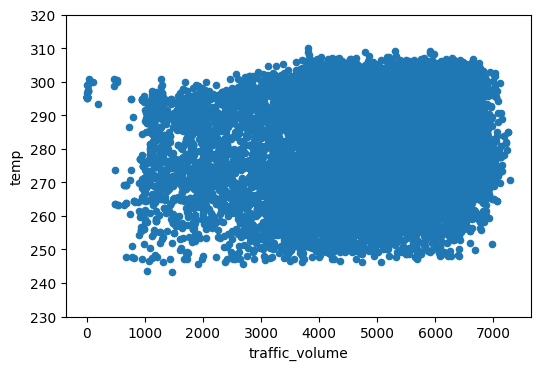

In [31]:
day.plot.scatter('traffic_volume','temp')
plt.ylim(230, 320) #exclude erroneous 0K temperatures

plt.plot()

There is no clear trend, so we can affirm there is no strong correlation between temperature and traffic volume.

Since none of the numerical columns yielded useful informationn, we'll turn to the categorical ones, namely `weather_main` and `weather_description`.  First, let's look at the description and value counts of these two columns.

In [32]:
day['weather_main'].describe()

count      23877
unique        11
top       Clouds
freq        8702
Name: weather_main, dtype: object

In [33]:
day['weather_main'].value_counts()

Clouds          8702
Clear           5744
Rain            2841
Mist            2593
Snow            1454
Drizzle          883
Haze             834
Thunderstorm     451
Fog              362
Smoke             12
Squall             1
Name: weather_main, dtype: int64

In [34]:
day['weather_description'].describe()

count            23877
unique              38
top       sky is clear
freq              4892
Name: weather_description, dtype: object

In [36]:
day['weather_description'].value_counts()

sky is clear                           4892
broken clouds                          2793
mist                                   2593
overcast clouds                        2585
scattered clouds                       2181
light rain                             1707
few clouds                             1143
light snow                              978
Sky is Clear                            852
haze                                    834
moderate rain                           785
light intensity drizzle                 573
fog                                     362
heavy snow                              320
proximity thunderstorm                  303
drizzle                                 278
heavy intensity rain                    219
snow                                    137
proximity shower rain                   111
thunderstorm                             48
heavy intensity drizzle                  29
thunderstorm with heavy rain             25
thunderstorm with light rain    

Both columns have a manageable number of unique values.  We can calculate the average traffic volume for each value to see if any correlate with traffic volume. 

In [37]:
by_weather_main = day.groupby('weather_main').mean()
by_weather_description = day.groupby('weather_description').mean()

[]

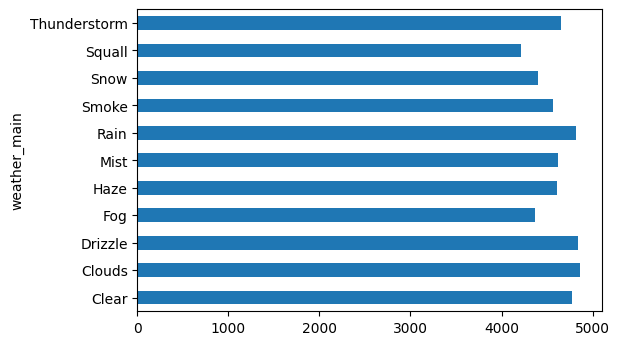

In [47]:
by_weather_main['traffic_volume'].plot.barh()
plt.plot()

Nothing stands out here.  Regardless of the weather type, volume averages between approximately 4500 and 5000 vehicles per hour. Let's look at `weather_description`

[]

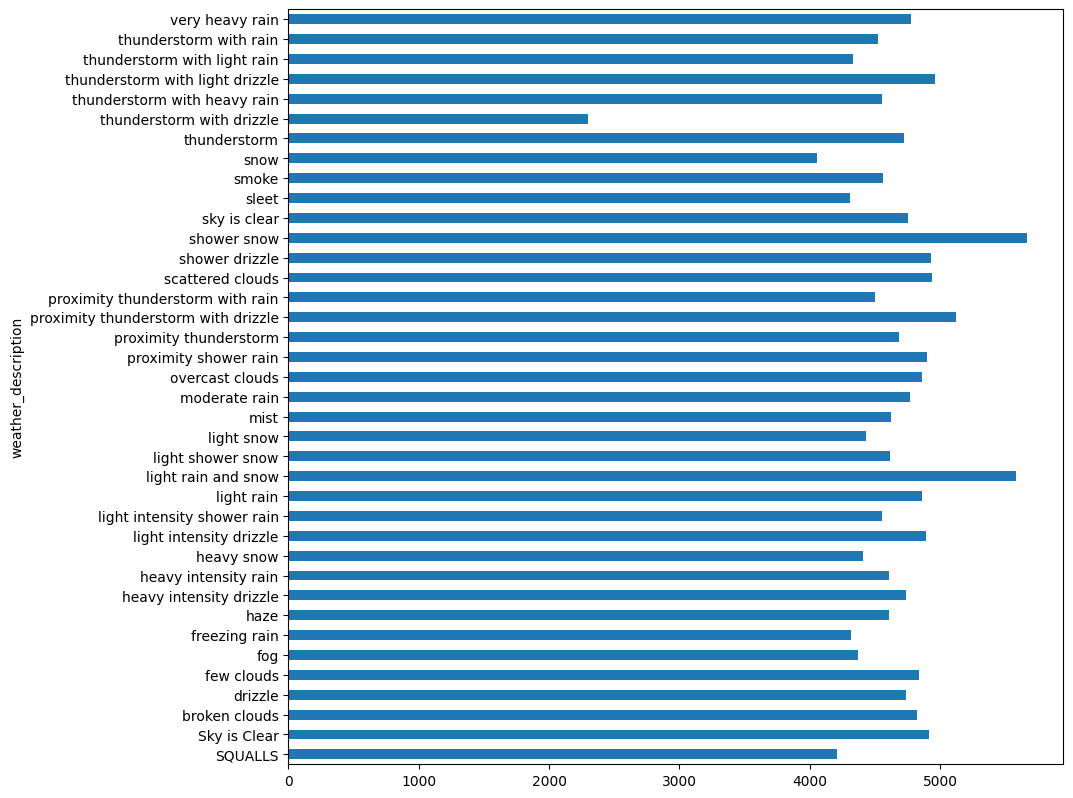

In [48]:
by_weather_description['traffic_volume'].plot.barh(figsize=(10,10))

plt.plot()

Now we have some interesting results.  While most of the averages fall in the 4,000-5,000 vph range, there are two above 5.000: Shower Snow and Light rain and snow.  There is also one around 2500, thunderstorm with drizzle.

## Conclusion

In this notebook, we have analyzed traffic flow indicators along westbound I-94 between Minneapolis and Saint Paul, Minnesota for dates between 2012 and 2017.  We first looked at time/date indicators and found that traffic is heavier during the day and on business days.  It also tends to be heavier in warmer months, with the slowest months being December and January.  

We then turned to weather indicators.  None of the numerical indicators showed any strong correlation with traffic volume, with temperature being the highest at +0.13.  Finally we examined the categorical columns of weather main and weather description and found little indication that weather affects the flow of traffic, with the possible exception of shhower snow and light rain and snow causing increased volume and thunderstorm and drizzle reducing the flow. 

Armed with this data and insights, we might be able to make recommendations to the local transportation departments that could help them plan the best times for road construction or develop strategies for how to prevent or mitigate overcrowded conditions during peak traffic times. 